In [38]:
import torch
import warnings
from scripts import dog_breed
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import os
from torchvision.datasets import ImageFolder
import shutil
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dog

#### Train dataset curation

##### Load the data and filter the Stanford dataset

In [2]:
specified_breeds = ['beagle', 'border_collie', 'chihuahua', 'chow',
                    'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever',
                    'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler',
                    'saint_bernard', 'samoyed', 'shih-tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [3]:
source_folder = 'stanford_dogs/images/Images/'
target_folder = 'filtered_dataset/train'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

In [4]:
dataset = ImageFolder('filtered_dataset/train/')

In [5]:
all_breeds = dataset.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 23
List of all breeds:
['beagle', 'border_collie', 'chihuahua', 'chow', 'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever', 'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler', 'saint_bernard', 'samoyed', 'shih-tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [6]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(2506, 278, 1192)

In [7]:
breeds = []

def rename(name):
    return name.split('-', 1)[-1].lower()

for n in dataset.classes:
    breeds.append(rename(n))

In [8]:
breeds

['beagle',
 'border_collie',
 'chihuahua',
 'chow',
 'cocker_spaniel',
 'doberman',
 'french_bulldog',
 'giant_schnauzer',
 'golden_retriever',
 'great_dane',
 'labrador_retriever',
 'malinois',
 'maltese_dog',
 'pekinese',
 'pug',
 'rottweiler',
 'saint_bernard',
 'samoyed',
 'tzu',
 'siberian_husky',
 'toy_poodle',
 'west_highland_white_terrier',
 'yorkshire_terrier']

In [9]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(2506, 278, 1192)

In [10]:
train_ds[0]

(<PIL.Image.Image image mode=RGB size=600x800>, 21)

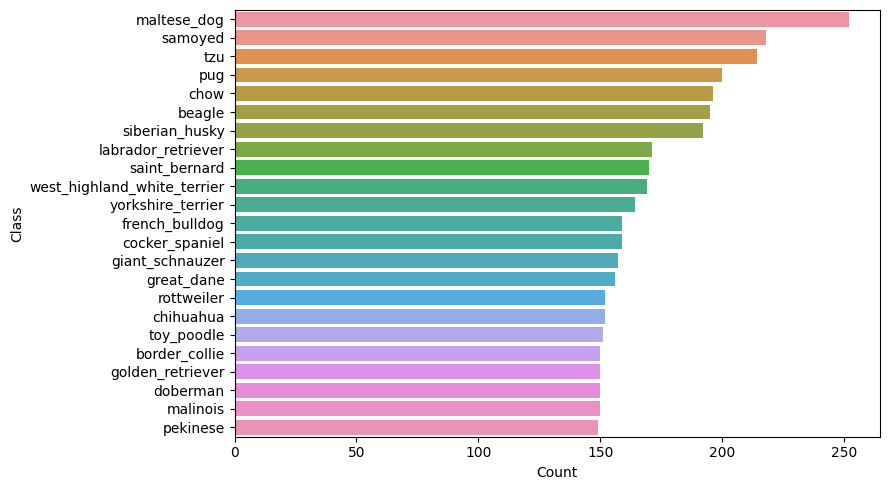

In [11]:
class_names = breeds
class_count = [dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count}).sort_values(by='Count', ascending=False)

plt.figure(figsize=(9,5), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

##### DataLoader

In [12]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [13]:
train_dataset = dog_breed.DogBreedDataset(train_ds, train_transform)
val_dataset = dog_breed.DogBreedDataset(val_ds, val_transform)
test_dataset = dog_breed.DogBreedDataset(test_ds, test_transform)

batch_size = 16

train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size*2)
test_dl = DataLoader(test_dataset, batch_size*2)

10


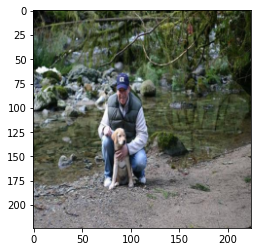

In [37]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

##### Train loop

In [15]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
num_classes = len(breeds)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    dog_breed.train_one_epoch(model, train_dl, criterion, optimizer, device)
    dog_breed.test_model(model, test_dl, criterion, device)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5


100%|██████████| 157/157 [00:15<00:00, 10.30it/s]


Train Loss: 1.6539 Acc: 0.6042
Test Loss: 0.7230 Acc: 0.8331
Epoch 2/5


100%|██████████| 157/157 [00:08<00:00, 17.99it/s]


Train Loss: 0.6885 Acc: 0.8372
Test Loss: 0.4575 Acc: 0.8800
Epoch 3/5


100%|██████████| 157/157 [00:08<00:00, 17.83it/s]


Train Loss: 0.4906 Acc: 0.8735
Test Loss: 0.4107 Acc: 0.8826
Epoch 4/5


100%|██████████| 157/157 [00:08<00:00, 18.15it/s]


Train Loss: 0.4190 Acc: 0.8803
Test Loss: 0.3746 Acc: 0.8893
Epoch 5/5


100%|██████████| 157/157 [00:08<00:00, 18.10it/s]


Train Loss: 0.3581 Acc: 0.8994
Test Loss: 0.3654 Acc: 0.8800


#### Test on scrapped dataset dog

In [16]:
specified_breeds = ['beagle', 'border_collie', 'chihuahua', 'chow',
                    'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever',
                    'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler',
                    'saint_bernard', 'samoyed', 'shih_tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [17]:
source_folder = 'breed_dataset/dog/'
target_folder = 'filtered_dataset/test'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

In [18]:
test_data_scrap = ImageFolder('filtered_dataset/test')

In [19]:
all_breeds = test_data_scrap.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 23
List of all breeds:
['beagle', 'border_collie', 'chihuahua', 'chow', 'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever', 'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler', 'saint_bernard', 'samoyed', 'shih_tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [20]:
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

batch_size = 8
test_dataset_scrap = dog_breed.DogBreedDataset(test_data_scrap, test_transform)
test_dl_scrap = DataLoader(test_dataset_scrap, batch_size*2)

def create_confusion_matrix(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions)
    return confusion

confusion_matrix_all_classes = create_confusion_matrix(model, test_dl_scrap)



  0%|          | 0/88 [00:00<?, ?it/s]

In [21]:
total_samples = len(test_dataset_scrap)
correct_predictions = sum(confusion_matrix_all_classes[i][i] for i in range(len(confusion_matrix_all_classes)))
accuracy = correct_predictions / total_samples

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 59.70%


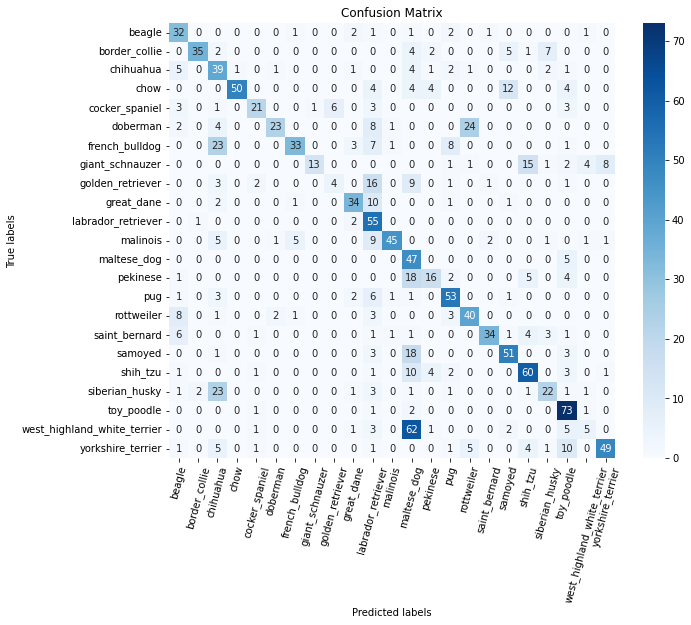

In [22]:
dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, specified_breeds)

## Cat

### Training

#### Mental illnesses

In [2]:
import os
import shutil

class_names = [
    'abyssinian', 'bengal', 'bombay',
    'british_shorthair', 'maine_coon', 'persian',
    'ragdoll', 'russian_blue', 'siamese', 'sphynx'
]

data_dir = 'oxford-iiit-pet/images/images/'

output_dir = 'filter_cat'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg'):
            for class_name in class_names:
                if class_name.lower() in file.lower():
                    src_path = os.path.join(root, file)
                    dst_path = os.path.join(output_dir, class_name, file)
                    shutil.copy(src_path, dst_path)
                    break 


In [4]:
dataset = ImageFolder('filter_cat/')

In [5]:
all_breeds = dataset.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 10
List of all breeds:
['abyssinian', 'bengal', 'bombay', 'british_shorthair', 'maine_coon', 'persian', 'ragdoll', 'russian_blue', 'siamese', 'sphynx']


In [6]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size
train_size = dataset_size

train_size,  test_size

(1400, 600)

In [7]:
train_ds_cat, test_ds_cat = random_split(dataset, [train_size, test_size])
len(train_ds_cat), len(test_ds_cat)

(1400, 600)

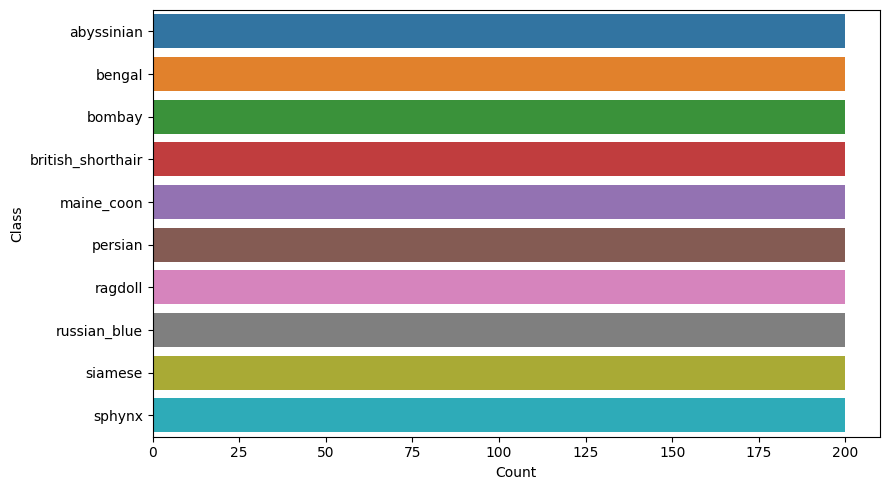

In [8]:
class_names = all_breeds
class_count = [dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count}).sort_values(by='Count', ascending=False)

plt.figure(figsize=(9,5), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [10]:
train_dataset = dog_breed.DogBreedDataset(train_ds_cat, train_transform)
test_dataset = dog_breed.DogBreedDataset(test_ds_cat, test_transform)

batch_size = 16

train_dl_cat = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl_cat = DataLoader(test_dataset, batch_size*2)

2


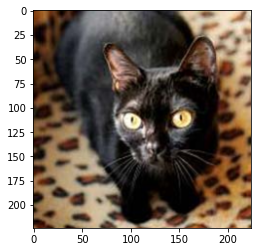

In [11]:
img, label = train_dataset[11]
print(label)
plt.imshow(img.permute(1,2,0))

#### Actual training

In [231]:



models_list = ["resnet18", "alexnet", "vgg19bn", "densenet", "mobilenetv3"]
for model_name in models_list:
    num_classes = len(all_breeds)
    model = dog_breed.get_pretrained_model(model_name, num_classes)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train, eval = dog_breed.train_and_test(model, model_name, train_dl_cat, test_dl_cat, criterion, optimizer, device, num_epochs=15)

    os.makedirs("breed_models/", exist_ok=True)
    model_filename = f"breed_models/{model_name}_best_model.pth"
    torch.save(model.state_dict(), model_filename)

Epoch 1/15


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.5287 Acc: 0.5214
Test Loss: 0.8515 Acc: 0.7983
Epoch 2/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.7572 Acc: 0.8136
Test Loss: 0.5495 Acc: 0.8667
Epoch 3/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.5447 Acc: 0.8621
Test Loss: 0.4628 Acc: 0.8700
Epoch 4/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4442 Acc: 0.8821
Test Loss: 0.4028 Acc: 0.8850
Epoch 5/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4071 Acc: 0.8921
Test Loss: 0.3857 Acc: 0.8717
Epoch 6/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3458 Acc: 0.9071
Test Loss: 0.3575 Acc: 0.8717
Epoch 7/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3292 Acc: 0.9036
Test Loss: 0.3383 Acc: 0.8883
Epoch 8/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2872 Acc: 0.9157
Test Loss: 0.3377 Acc: 0.8817
Epoch 9/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2540 Acc: 0.9336
Test Loss: 0.3169 Acc: 0.8967
Epoch 10/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2580 Acc: 0.9243
Test Loss: 0.3263 Acc: 0.8950
Epoch 11/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2509 Acc: 0.9257
Test Loss: 0.3130 Acc: 0.9000
Epoch 12/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2416 Acc: 0.9257
Test Loss: 0.3100 Acc: 0.9000
Epoch 13/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2066 Acc: 0.9364
Test Loss: 0.3223 Acc: 0.8883
Epoch 14/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2317 Acc: 0.9300
Test Loss: 0.3330 Acc: 0.8900
Epoch 15/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1917 Acc: 0.9500
Test Loss: 0.3241 Acc: 0.8983


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.3635 Acc: 0.5136
Test Loss: 1.0809 Acc: 0.6017
Epoch 2/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.8593 Acc: 0.6929
Test Loss: 0.9836 Acc: 0.6467
Epoch 3/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.6751 Acc: 0.7479
Test Loss: 0.8773 Acc: 0.6917
Epoch 4/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.5899 Acc: 0.7814
Test Loss: 0.8992 Acc: 0.6733
Epoch 5/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.6049 Acc: 0.7879
Test Loss: 0.9690 Acc: 0.6600
Epoch 6/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.5121 Acc: 0.8157
Test Loss: 0.9458 Acc: 0.6983
Epoch 7/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4575 Acc: 0.8350
Test Loss: 0.9891 Acc: 0.6967
Epoch 8/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4274 Acc: 0.8493
Test Loss: 0.9596 Acc: 0.6900
Epoch 9/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4206 Acc: 0.8557
Test Loss: 0.9424 Acc: 0.6950
Epoch 10/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4017 Acc: 0.8521
Test Loss: 0.9862 Acc: 0.6867
Epoch 11/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3396 Acc: 0.8764
Test Loss: 1.0955 Acc: 0.6483
Epoch 12/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3604 Acc: 0.8729
Test Loss: 1.0129 Acc: 0.6733
Epoch 13/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3499 Acc: 0.8757
Test Loss: 1.0798 Acc: 0.6967
Epoch 14/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3244 Acc: 0.8879
Test Loss: 1.0627 Acc: 0.6717
Epoch 15/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3499 Acc: 0.8779
Test Loss: 1.1437 Acc: 0.6650


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.7798 Acc: 0.7421
Test Loss: 0.3768 Acc: 0.8650
Epoch 2/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3692 Acc: 0.8771
Test Loss: 0.3002 Acc: 0.8883
Epoch 3/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2856 Acc: 0.9064
Test Loss: 0.3061 Acc: 0.8833
Epoch 4/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2731 Acc: 0.9021
Test Loss: 0.3035 Acc: 0.8883
Epoch 5/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2600 Acc: 0.9079
Test Loss: 0.2815 Acc: 0.8983
Epoch 6/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2243 Acc: 0.9171
Test Loss: 0.3261 Acc: 0.8933
Epoch 7/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2564 Acc: 0.9129
Test Loss: 0.3228 Acc: 0.8883
Epoch 8/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2147 Acc: 0.9229
Test Loss: 0.2829 Acc: 0.8883
Epoch 9/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2085 Acc: 0.9279
Test Loss: 0.3252 Acc: 0.8800
Epoch 10/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1898 Acc: 0.9350
Test Loss: 0.3115 Acc: 0.8900
Epoch 11/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2058 Acc: 0.9257
Test Loss: 0.3464 Acc: 0.8817
Epoch 12/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1956 Acc: 0.9329
Test Loss: 0.3203 Acc: 0.8900
Epoch 13/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1936 Acc: 0.9257
Test Loss: 0.3071 Acc: 0.8917
Epoch 14/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1670 Acc: 0.9400
Test Loss: 0.3187 Acc: 0.8867
Epoch 15/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1467 Acc: 0.9471
Test Loss: 0.3068 Acc: 0.8900


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.4337 Acc: 0.6193
Test Loss: 0.8013 Acc: 0.8067
Epoch 2/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.6906 Acc: 0.8471
Test Loss: 0.4856 Acc: 0.8883
Epoch 3/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4820 Acc: 0.8757
Test Loss: 0.4026 Acc: 0.8883
Epoch 4/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3583 Acc: 0.9143
Test Loss: 0.3486 Acc: 0.9100
Epoch 5/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3198 Acc: 0.9143
Test Loss: 0.3183 Acc: 0.9017
Epoch 6/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2915 Acc: 0.9186
Test Loss: 0.2947 Acc: 0.9117
Epoch 7/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2564 Acc: 0.9350
Test Loss: 0.2612 Acc: 0.9283
Epoch 8/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2388 Acc: 0.9350
Test Loss: 0.2794 Acc: 0.9133
Epoch 9/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2188 Acc: 0.9379
Test Loss: 0.2685 Acc: 0.9117
Epoch 10/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1881 Acc: 0.9507
Test Loss: 0.2465 Acc: 0.9167
Epoch 11/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1898 Acc: 0.9500
Test Loss: 0.2620 Acc: 0.9200
Epoch 12/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1799 Acc: 0.9421
Test Loss: 0.2508 Acc: 0.9233
Epoch 13/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1569 Acc: 0.9600
Test Loss: 0.2454 Acc: 0.9167
Epoch 14/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1360 Acc: 0.9664
Test Loss: 0.2429 Acc: 0.9233
Epoch 15/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1455 Acc: 0.9614
Test Loss: 0.2505 Acc: 0.9117
Epoch 1/15


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.2340 Acc: 0.6529
Test Loss: 0.6418 Acc: 0.8150
Epoch 2/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.5563 Acc: 0.8693
Test Loss: 0.7200 Acc: 0.7567
Epoch 3/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.4078 Acc: 0.8843
Test Loss: 0.6192 Acc: 0.7933
Epoch 4/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.3519 Acc: 0.9057
Test Loss: 0.4769 Acc: 0.8383
Epoch 5/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2810 Acc: 0.9221
Test Loss: 0.4334 Acc: 0.8450
Epoch 6/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2455 Acc: 0.9393
Test Loss: 0.4241 Acc: 0.8467
Epoch 7/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.2117 Acc: 0.9457
Test Loss: 0.4313 Acc: 0.8517
Epoch 8/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1785 Acc: 0.9593
Test Loss: 0.4377 Acc: 0.8400
Epoch 9/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1697 Acc: 0.9571
Test Loss: 0.4338 Acc: 0.8383
Epoch 10/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1573 Acc: 0.9593
Test Loss: 0.4272 Acc: 0.8400
Epoch 11/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1479 Acc: 0.9593
Test Loss: 0.4279 Acc: 0.8383
Epoch 12/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1267 Acc: 0.9714
Test Loss: 0.4449 Acc: 0.8483
Epoch 13/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1128 Acc: 0.9771
Test Loss: 0.4402 Acc: 0.8500
Epoch 14/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1153 Acc: 0.9700
Test Loss: 0.4537 Acc: 0.8433
Epoch 15/15


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.1056 Acc: 0.9714
Test Loss: 0.4628 Acc: 0.8483


  0%|          | 0/19 [00:00<?, ?it/s]

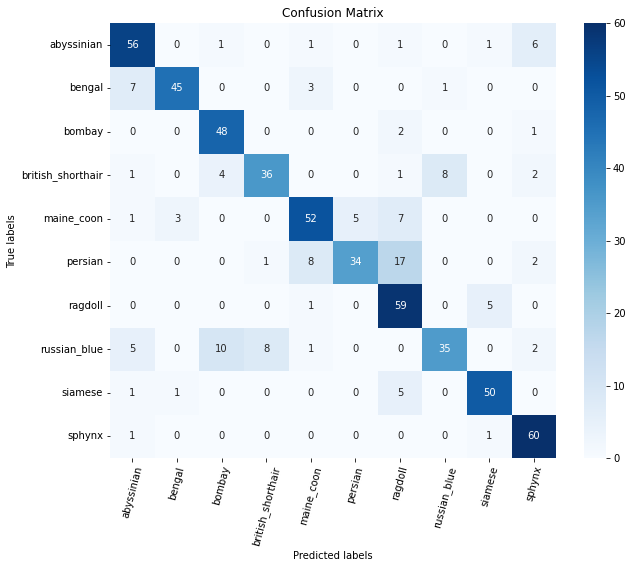

In [217]:
confusion_matrix_all_classes = dog_breed.create_confusion_matrix(model, test_dl_cat)
dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, all_breeds)

### Result Analysis

In [2]:
model_accuracies_dict, model_test_accuracies_dict, model_losses_dict, last_true_labels, last_model_preds, model_names = dog_breed.load_the_results()

#### Confusion Matrices

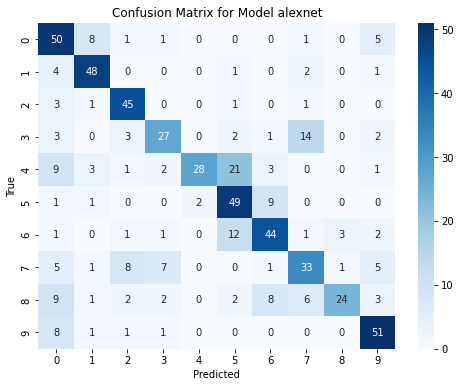

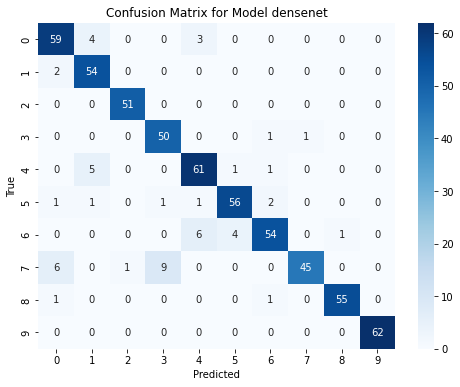

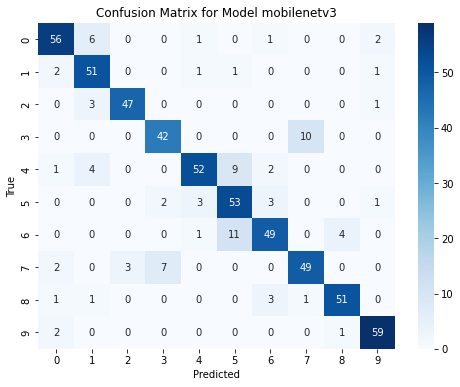

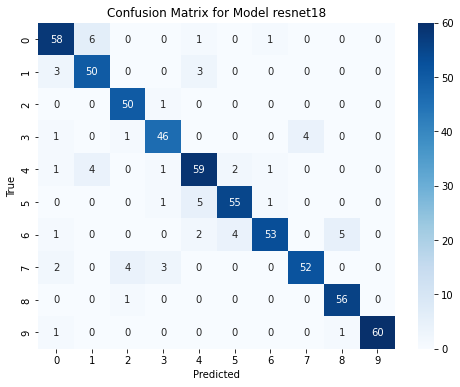

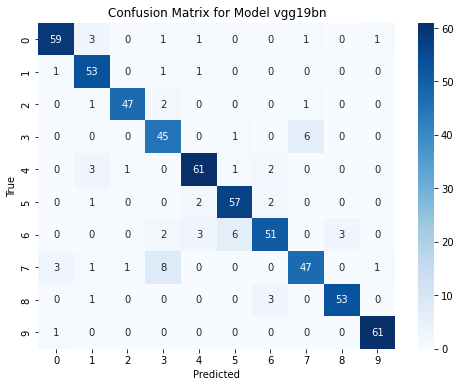

In [3]:
confusion_matrices = []

for true_labels, model_preds in zip(last_true_labels, last_model_preds):
    cm = confusion_matrix(true_labels, model_preds)
    confusion_matrices.append(cm)

for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
                xticklabels=np.unique(last_true_labels[i]), 
                yticklabels=np.unique(last_true_labels[i]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Model {model_names[i]}')
    plt.show()


#### Accuracies

##### Train Accuracies

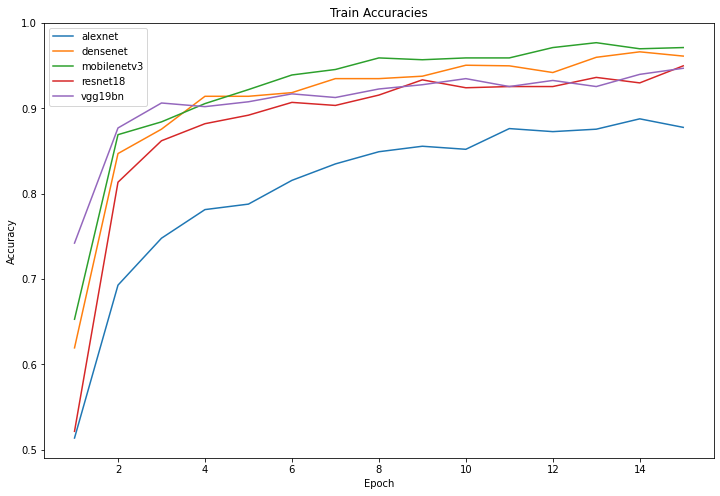

In [4]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_accuracies_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model)

plt.title('Train Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

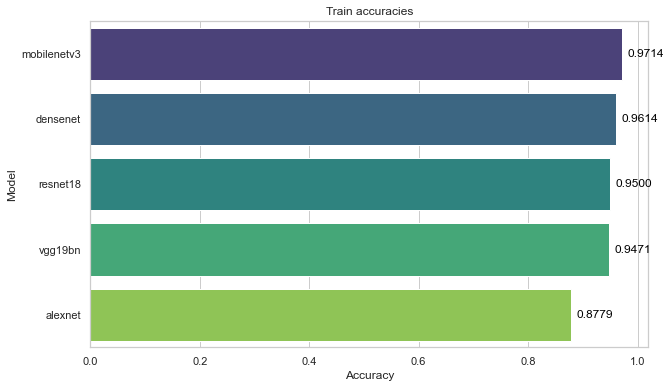

In [5]:
last_accuracies = [accuracies[-1] for accuracies in model_accuracies_dict.values()]
models = list(model_accuracies_dict.keys())

sorted_data = sorted(zip(last_accuracies, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.title('Train accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


##### Test Accuracies

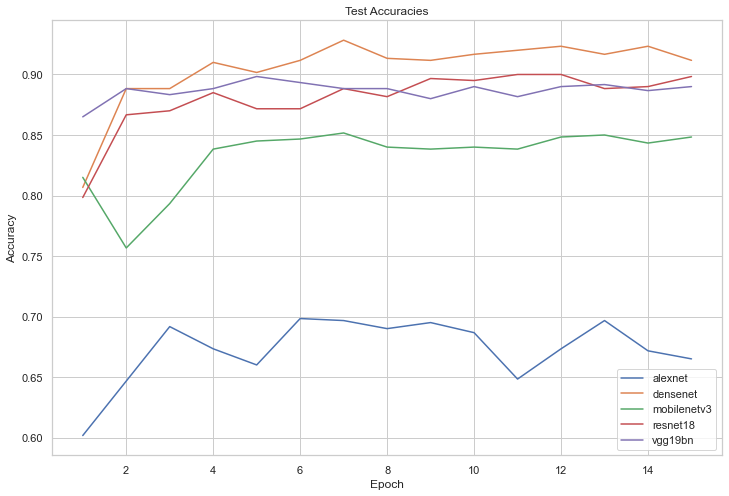

In [7]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_test_accuracies_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model)

plt.title('Test Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

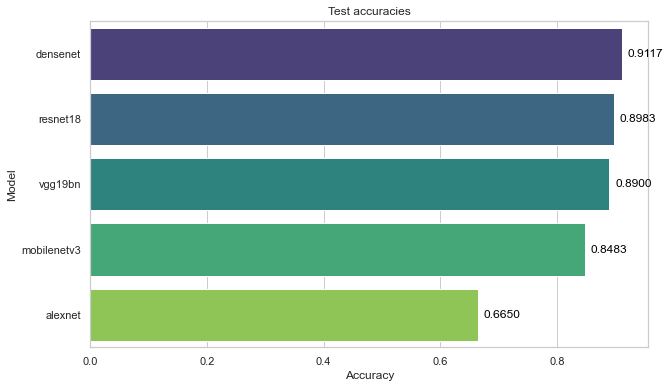

In [8]:
last_accuracies = [accuracies[-1] for accuracies in model_test_accuracies_dict.values()]
models = list(model_test_accuracies_dict.keys())

sorted_data = sorted(zip(last_accuracies, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.title('Test accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


##### Train loss

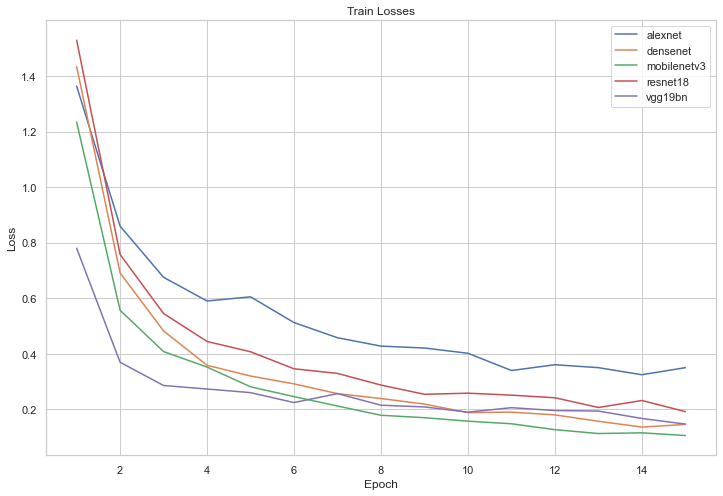

In [9]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_losses_dict.items():
    
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=model)

plt.title('Train Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Test on scrapped dataset cat

In [19]:
class_names = [
    'abyssinian', 'bengal', 'bombay',
    'british_shorthair', 'maine_coon', 'persian',
    'ragdoll', 'russian_blue', 'siamese', 'sphynx'
]

In [33]:
results_directory = 'breed_models/'
all_files = os.listdir(results_directory)
model_files = [file for file in all_files if file.endswith('.pth')]
model_names = [file.split('_')[0] for file in model_files]

['alexnet', 'densenet', 'mobilenetv3', 'resnet18', 'vgg19bn']

  0%|          | 0/55 [00:00<?, ?it/s]

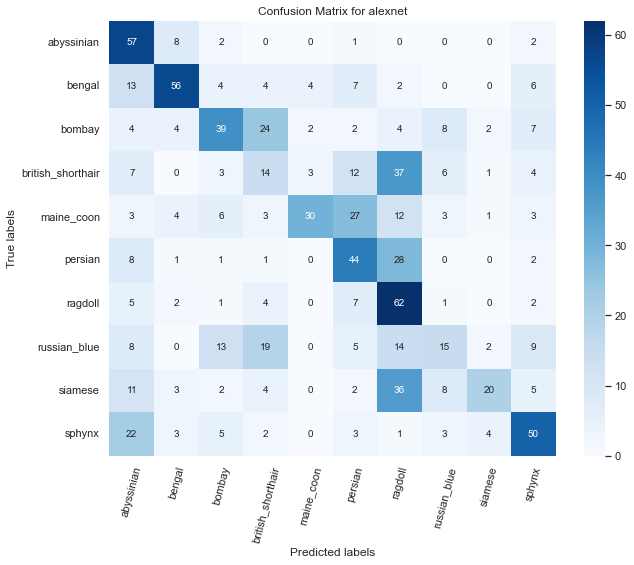

Accuracy: 44.03%


  0%|          | 0/55 [00:00<?, ?it/s]

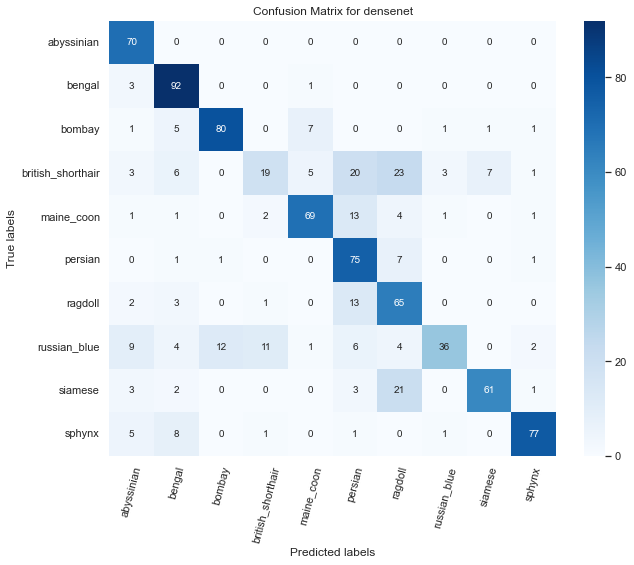

Accuracy: 73.27%


  0%|          | 0/55 [00:00<?, ?it/s]

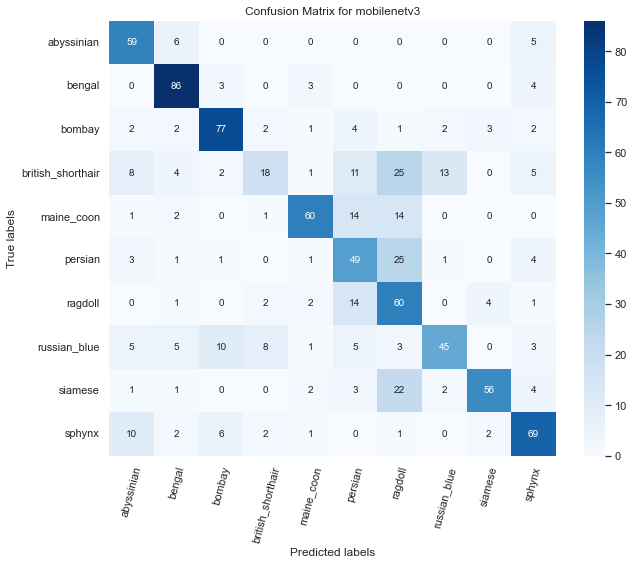

Accuracy: 65.87%


  0%|          | 0/55 [00:00<?, ?it/s]

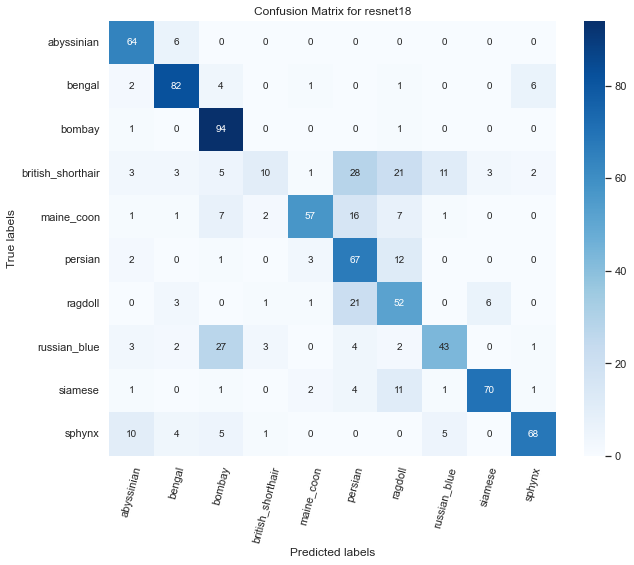

Accuracy: 69.06%


  0%|          | 0/55 [00:00<?, ?it/s]

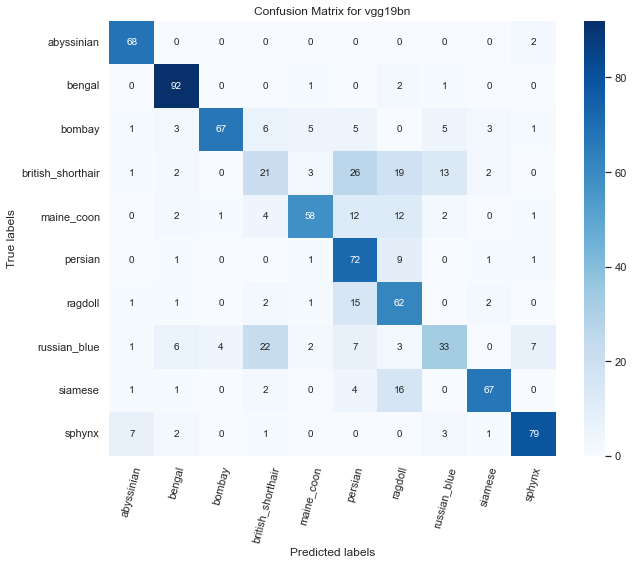

Accuracy: 70.42%


In [41]:
test_data_scrap_cat = ImageFolder('breed_dataset/cat/')
test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])
accuracies_scrap = {}
for model_name in model_names:
    state_dict = torch.load(f"breed_models/{model_name}_best_model.pth")
    model = dog_breed.get_pretrained_model(model_name, num_classes)

    model.load_state_dict(state_dict)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    batch_size = 8
    test_dataset_scrap = dog_breed.CatBreedDataset(test_data_scrap_cat, test_transform)
    test_dl_scrap = DataLoader(test_dataset_scrap, batch_size*2)

    confusion_matrix_all_classes = dog_breed.create_confusion_matrix(model, test_dl_scrap)
    dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, class_names, model_name)
    
    total_samples = len(test_dataset_scrap)
    correct_predictions = sum(confusion_matrix_all_classes[i][i] for i in range(len(confusion_matrix_all_classes)))
    accuracy = correct_predictions / total_samples
    accuracies_scrap[model_name] = accuracy
    print(f"Accuracy: {accuracy * 100:.2f}%")



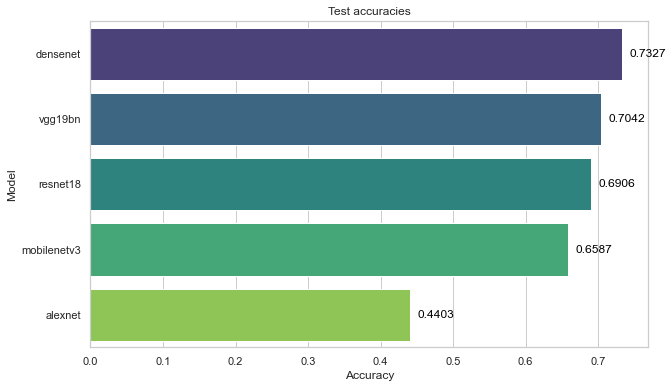

In [46]:
last_accuracies = [accuracies for accuracies in accuracies_scrap.values()]
models = list(accuracies_scrap.keys())

sorted_data = sorted(zip(last_accuracies, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.title('Test accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()
